,

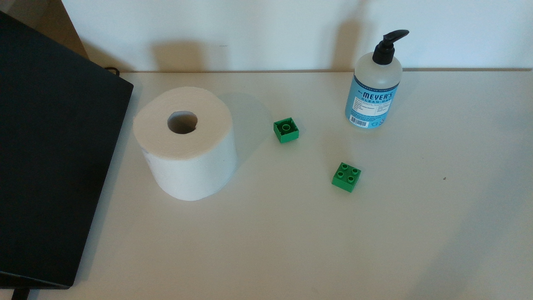
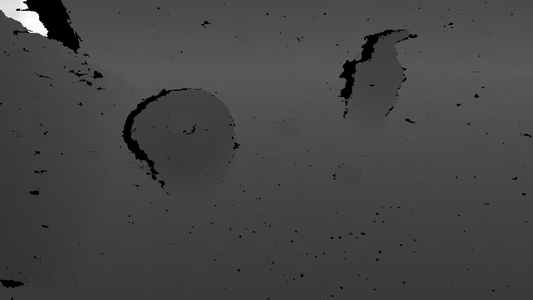

In [5]:
from PIL import Image
import numpy as np
import mediapy as media

# Load scene (from RealSense Depth Camera)
rgb = Image.open("./data/scene/rgb.png")
depth = Image.open("./data/scene/depth.png")
cam_K = np.loadtxt("./data/scene/cam_K.txt").reshape(3,3)

# Define mesh files
mesh_name = "hand_soap"
mesh_obj_path = f"./data/meshes/{mesh_name}/mesh.obj"
mesh_mtl_path = f"./data/meshes/{mesh_name}/mesh.obj.mtl"
mesh_png_path = f"./data/meshes/{mesh_name}/texture.png"

media.show_images([rgb, depth], height=300)

1
dict_keys(['class_name', 'bbox', 'segmentation', 'score', 'confidence'])


""

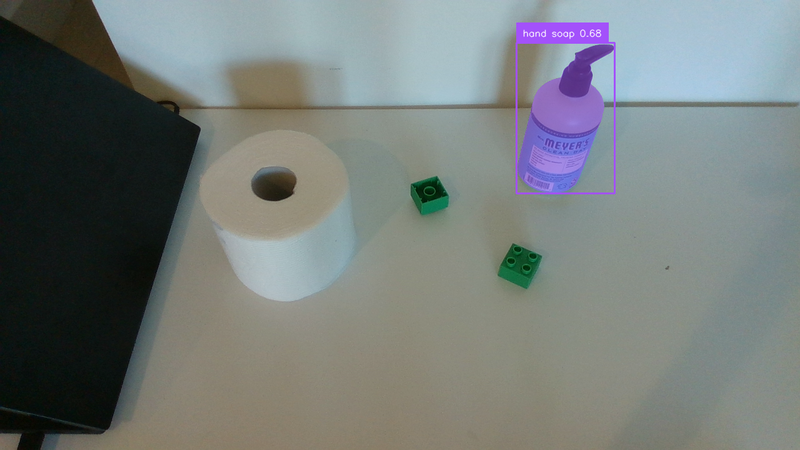

In [6]:
import io, base64
from trlc_sdk.http.client import HTTPClient
from trlc_sdk.utils.visualization import annotate_image

client = HTTPClient()

# Define text prompt for segmentation (e.g. "lego_brick" -> "lego brick.")
text_prompt = mesh_name.replace("_", " ") + "."

buffer = io.BytesIO()
rgb.convert("RGB").save(buffer, format="PNG")
image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

segmentation_results = client.segment(image_base64, text_prompt)

print(len(segmentation_results["annotations"]))
print(segmentation_results["annotations"][0].keys())

annotated_frame = annotate_image(segmentation_results["annotations"], rgb)
media.show_image(annotated_frame, height=450)

""

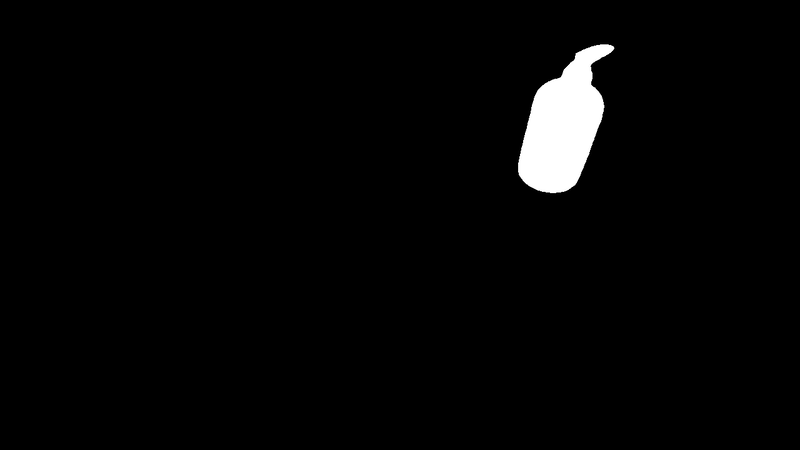

In [7]:
# Select mask
idx = 0
mask = segmentation_results["annotations"][idx]["segmentation"]
media.show_image(mask, height=450)

[[-0.96055299  0.00259967  0.27808455  0.16851388]
 [-0.2250694  -0.59460855 -0.77187067 -0.05613203]
 [ 0.16334487 -0.80401111  0.57173824  0.64571548]
 [ 0.          0.          0.          1.        ]]


posed_3d_box,xyz_axis

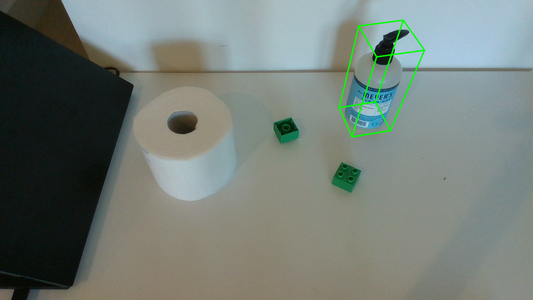
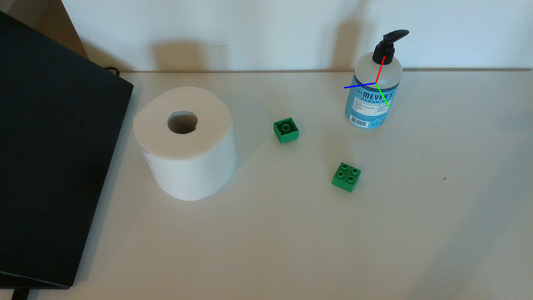

In [8]:
import trimesh

from trlc_sdk.utils.network import encode_file, encode_image
from trlc_sdk.utils.visualization import draw_posed_3d_box, draw_xyz_axis

client = HTTPClient()
pose_results = client.estimate_pose(
    rgb_base64=encode_image(rgb),
    depth_base64=encode_image(depth),
    mask_base64=encode_image(Image.fromarray(mask)),
    cam_K=cam_K.tolist(),
    mesh_obj=encode_file(mesh_obj_path),
    mesh_mtl=encode_file(mesh_mtl_path),
    mesh_png=encode_file(mesh_png_path)
)

pose = np.array(pose_results["results"]).reshape(4,4)
print(pose)

# Show results
mesh = trimesh.load(mesh_obj_path)
to_origin, extents = trimesh.bounds.oriented_bounds(mesh)
bbox = np.stack([-extents/2, extents/2], axis=0).reshape(2,3)

center_pose = pose@np.linalg.inv(to_origin)

visualization = {
    "posed_3d_box": draw_posed_3d_box(
        K=cam_K, 
        img=np.array(rgb), 
        ob_in_cam=center_pose, 
        bbox=bbox, 
        line_color=(0,255,0), 
        linewidth=2
    ),
    "xyz_axis": draw_xyz_axis(
        color=np.array(rgb), 
        ob_in_cam=center_pose, 
        K=cam_K, 
        thickness=2,
        scale=0.05
    )
}
media.show_images(visualization, height=300)